# Ficha #05 - Criação automática das máscaras do dataset DRIVE

In [1]:
%pylab inline

# Third-party libraries
import numpy as np, mahotas 
import skimage
import matplotlib
from skimage import filters, feature
from io import BytesIO
from IPython.display import Image
from ipywidgets import interact, interactive, fixed
from scipy import fftpack, ndimage, signal
import math, copy
gray()

Populating the interactive namespace from numpy and matplotlib


**Objectivo**: Neste trabalho usando as técnicas que julgar mais adequadas deve gerar automaticamente as máscaras do conjunto de imagens do DRIVE. A máscara permite extrair a zona central de interesse da image de fundo de olho. Na validação do seu trabalho deve sobrepor vários perfis de intensidade da máscara e da imagem de fundo de olho na direcção horizontal como na vertical.

In [2]:
image = imread("./DRIVE/training/images/28_training.tif")
img_teste = (image[:,:,1])

In [3]:
def labeling(img):
    # Determinar o sub conjunto de objetos da imagem
    labeling, nr_objetos = mahotas.label(img)
   
    return labeling, nr_objetos

def remove_regions(labeling):
    # Determinar o tamanho de cada objeto da imagem 
    tamanhos = mahotas.labeled.labeled_size(labeling)
    
    tamanhos.sort()
    
    # Remover o fundo da imagems
    t_borda = tamanhos[1]
    fundo = np.where(tamanhos > t_borda)
    removidos = mahotas.labeled.remove_regions(labeling, fundo)
    
    return removidos     

In [4]:
def perfil_intensidades(img1, img2):
    c1 = 150
    c2 = 250
    c3 = 450
    
    _, ax = subplots(2, 3, figsize = (15,10))
    ax[0,0].plot(img1[c1][0:100])
    ax[0,0].plot(img2[c1][0:100]*255)
    ax[0,0].set_title("Perfil intensidade 1º transição - linha " 
                                                          + str(c1))
    ax[0,1].plot(img1[c2][0:100])
    ax[0,1].plot(img2[c2][0:100]*255)
    ax[0,1].set_title("Perfil intensidade 1º transição - linha "
                                                          + str(c2))
    ax[0,2].plot(img1[c3][0:100])
    ax[0,2].plot(img2[c3][0:100]*255)
    ax[0,2].set_title("Perfil intensidade 1º transição - linha " 
                                                          + str(c3))
    
    ax[1,0].plot(img1[c1][450:])
    ax[1,0].plot(img2[c1][450:]*255)
    ax[1,0].set_title("Perfil intensidade transição final - linha " 
                                                          + str(c1))
    ax[1,1].plot(img1[c2][450:])
    ax[1,1].plot(img2[c2][450:]*255)
    ax[1,1].set_title("Perfil intensidade transição final - linha "
                                                          + str(c2))
    ax[1,2].plot(img1[c3][450:])
    ax[1,2].plot(img2[c3][450:]*255)
    ax[1,2].set_title("Perfil intensidade transição final - linha " 
                                                          + str(c3))

In [5]:
''' - Função de binarização. 
    - Recebe como parametros a imagem a binarizar e um parametro de nome "detalhes", usado para
saber se imprime ou não gráficos que demonstram o processo. 
    - Retorna a matriz binária da imagem binarizada e o valor de corte 
utilizado para o threshold ''' 
def binarizacao(img, detalhes=0):
    gray()
    # bin começa como uma matriz de zeors
    bin = zeros_like(img)
    
    # Valor a aplicar como treshold à imagem
    #threshold_otsu = mahotas.otsu(img.astype('uint8'))
    threshold_otsu = skimage.filters.threshold_otsu(img.astype('uint8'))
    
    # Nas posições da imagem inicial onde a intensidade do pixel seja 
    # superior à intensidade de corte definida pelo threshold, o pixel 
    # toma o valor de 1 (branco)
    # for i in range(img.shape[0]):
    #   for j in range(img.shape[1]):
    #       if(img[i,j] > threshold_otsu):
    #           bin[i,j] = 1  
    bin = img > threshold_otsu
    
    if(detalhes == 1):
        _, ax = subplots(1,2,figsize = (15,15))
        ax[0].imshow(img)
        ax[0].set_title("imagem original")
        ax[1].imshow(bin)
        ax[1].set_title("Após binerização")

        perfil_intensidades(img, bin)
     
    return bin, threshold_otsu

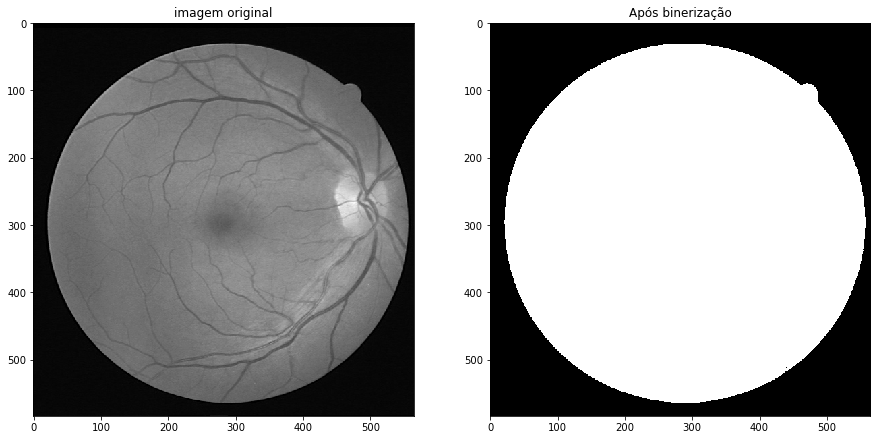

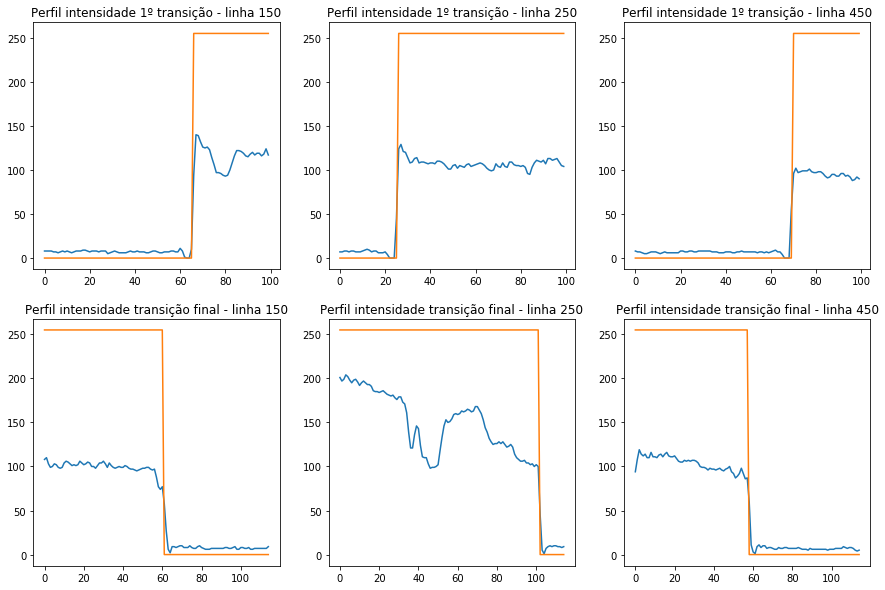

In [6]:
b, t = binarizacao(img_teste, 1)

In [25]:
def mascaras(img, detalhes=0):
    jet()
    
    # Gradiente
    # Aplicação do filtro de canny à imagem iriginal, para ficar apenas com os realces das transições fortes 
    f_canny = skimage.feature.canny(img, sigma=2)
    # Binarização da imagem resultante da aplicação do filtro de Canny à imagem origina. 
    # Binariza os contornos acentuados, levantados através do filtro de Canny
    bin_f_canny, _ = binarizacao(f_canny)
    
    # Aplicação da morfologia matemática de dilatação ao resultado da binarização do filtro de Canny, 
    # como forma de completar e evidenciar o contorno da borda da retirna. 
    dil_bin_f_canny = ndimage.morphology.binary_dilation(bin_f_canny)

    # Utilizar a função labeling para remover o fundo interior e ficar só com a borda
    labels, n = labeling(dil_bin_f_canny)
    borda_reg = remove_regions(labels)
    
    borda_retina_mask = borda_reg
    retina_mask = ndimage.morphology.binary_fill_holes(borda_retina_mask)
    
    if(detalhes==1):
        
        f , ax = subplots(1,4,figsize = (35,100))
        f.subplots_adjust(right = 0.5)
        
        ax[0].imshow(img)
        ax[0].set_title("Imagem original")
        
        gray()
        ax[1].set_title("Filtro canny (transições)")
        ax[1].imshow(f_canny)
        
        gray()
        ax[2].imshow(retina_mask)
        ax[2].set_title("mascara")
        
        ax[3].imshow(borda_retina_mask)
        ax[3].set_title("borda ")
    
    return (retina_mask, borda_retina_mask)

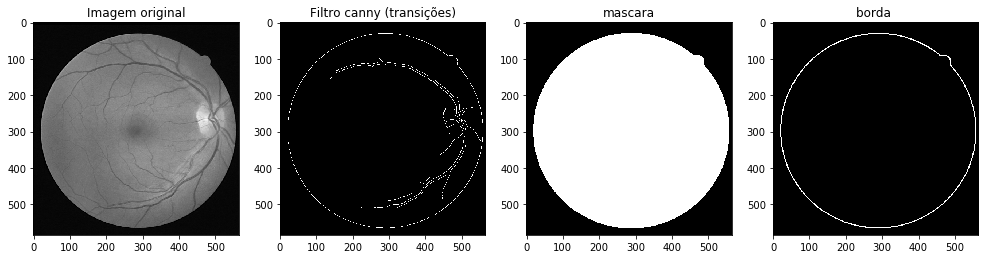

In [26]:
m, mb = mascaras(img_teste,1)

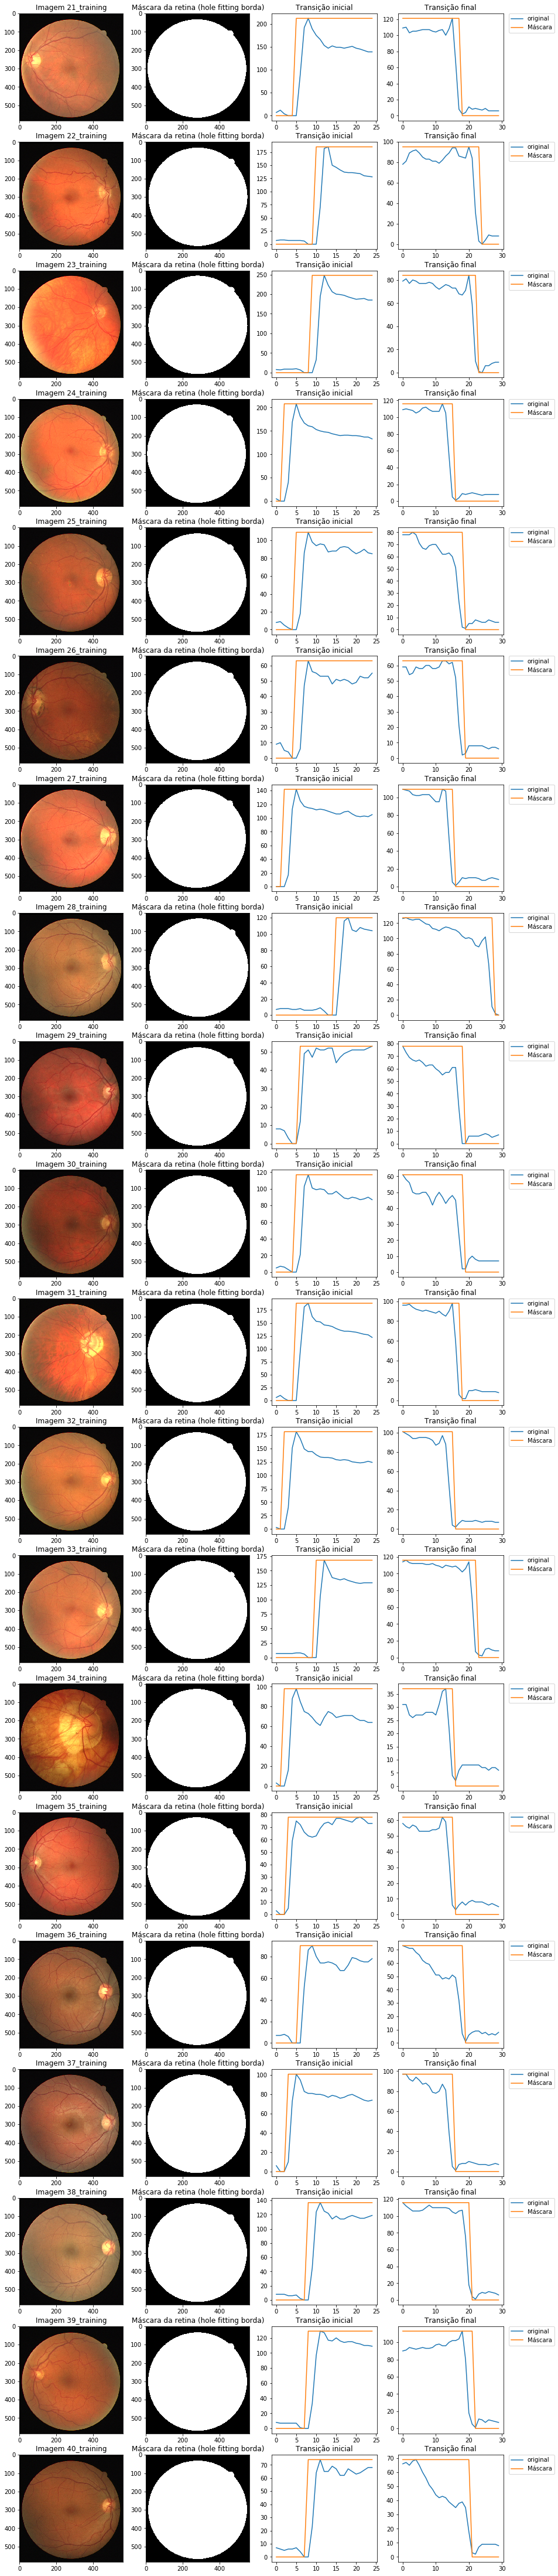

In [27]:
f, ax = subplots(20,4,figsize = (20,80))
f.subplots_adjust(right = 0.7)

for i in range(21,41):
    img = imread("./DRIVE/training/images/" +str(i)+ "_training.tif")
    teste = img[:,:,1]
    P, Q = teste.shape
    
    m, mb = mascaras(teste)

    ax[i-21,0].imshow(img)
    ax[i-21,0].set_title("Imagem "  +str(i)+ "_training")
    ax[i-21,1].imshow(m)
    ax[i-21,1].set_title("Máscara da retina (hole fitting borda)")

    ax[i-21,2].set_title("Transição inicial")
    ax[i-21,2].plot(teste[P//2][5:30], label="original")
    ax[i-21,2].plot(m[P//2][5:30]*teste[P//2][5:30].max(), label="Máscara")

    ax[i-21,3].set_title("Transição final")
    ax[i-21,3].plot(teste[P//2][530:560], label="original")
    ax[i-21,3].plot(m[P//2][530:560]*teste[P//2][530:560].max(), label="Máscara")
    ax[i-21,3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

C:\Users\migue\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


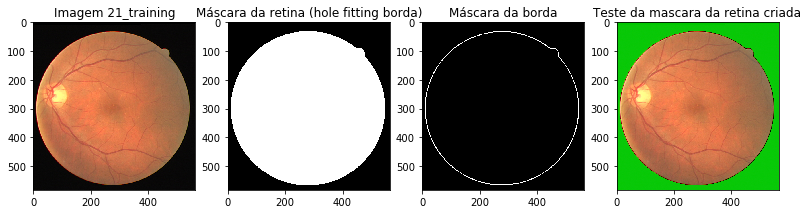

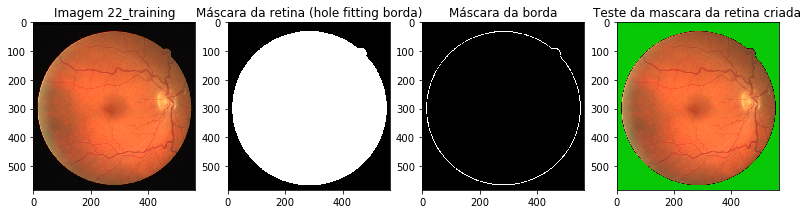

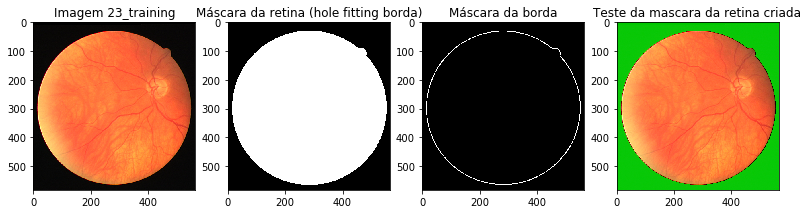

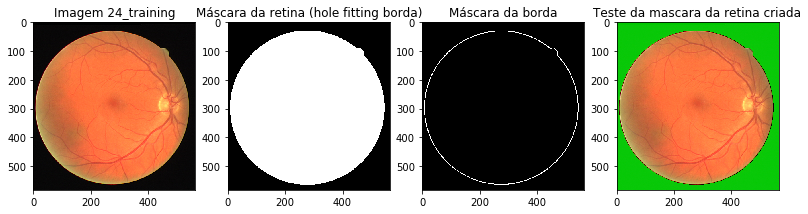

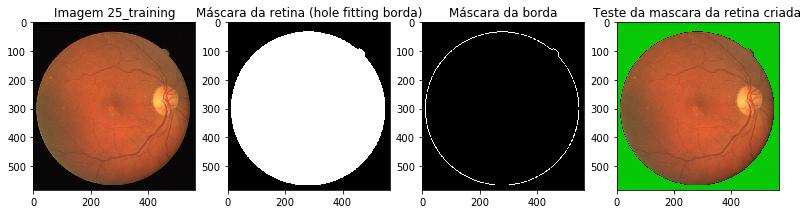

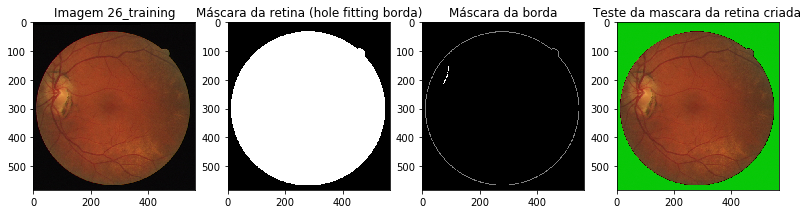

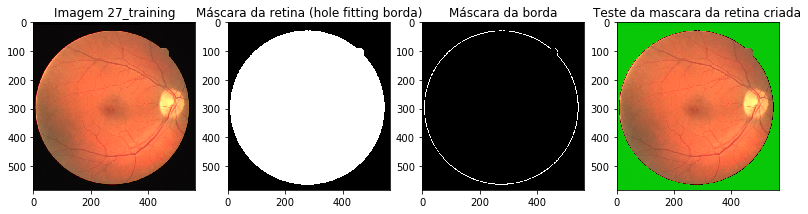

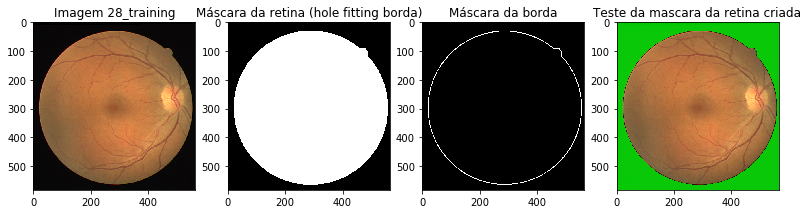

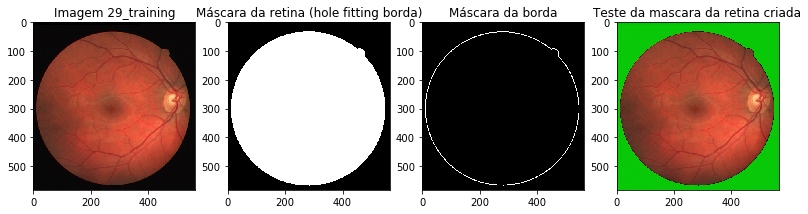

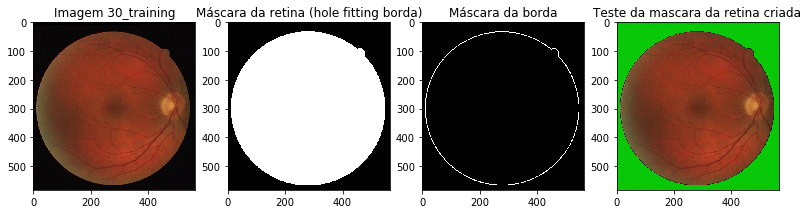

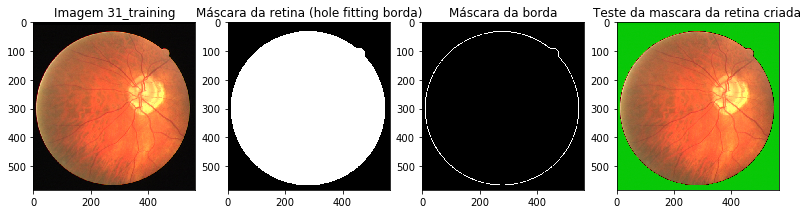

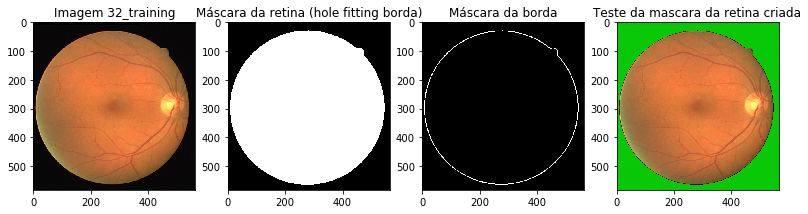

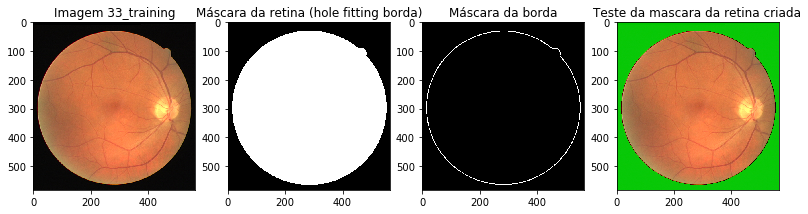

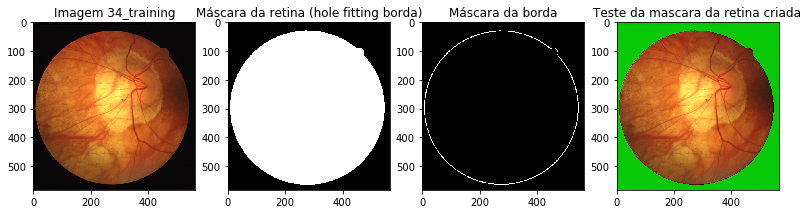

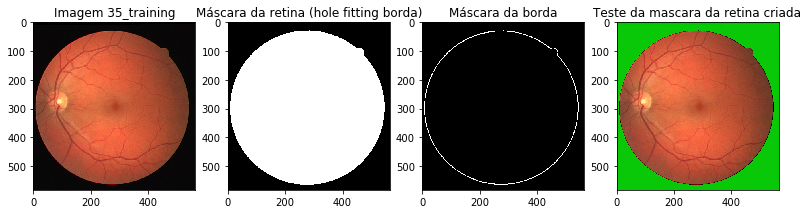

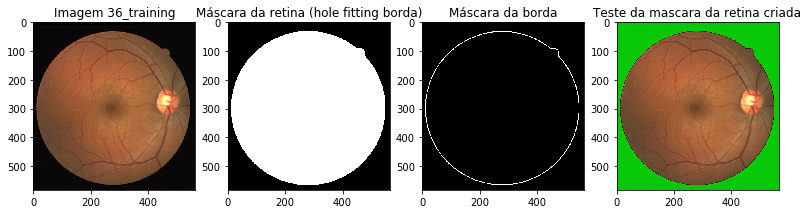

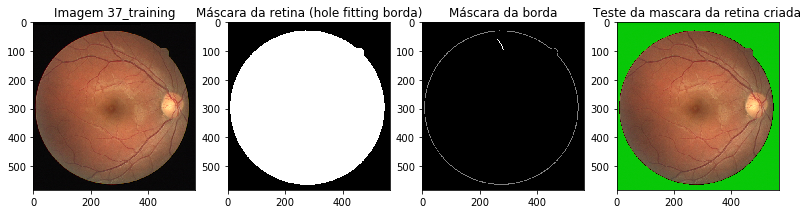

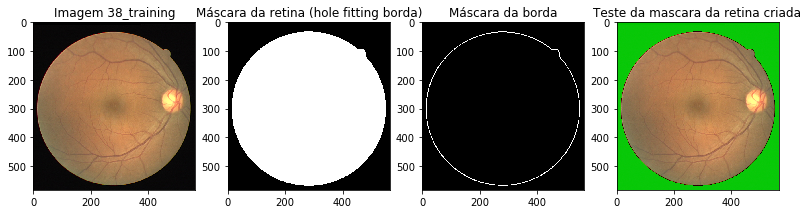

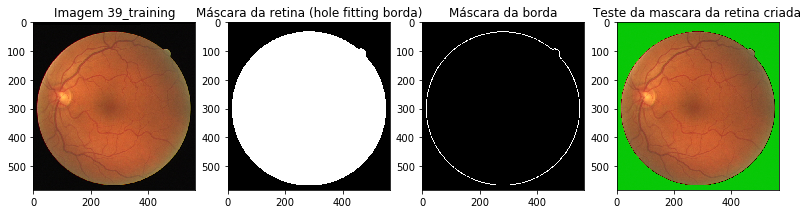

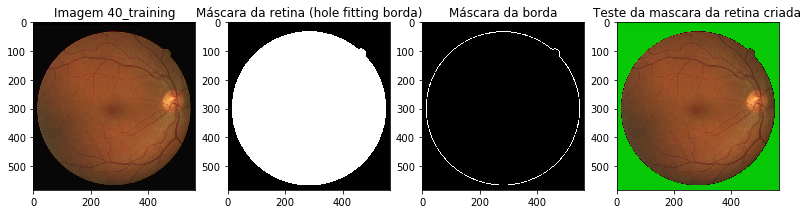

In [28]:
for i in range(21,41):
    img = imread("./DRIVE/training/images/" +str(i)+ "_training.tif")
    teste = img[:,:,1]
    
    m, mb = mascaras(teste)
    f, ax = subplots(1,4,figsize = (18,30))
    f.subplots_adjust(right = 0.7)
    
    ax[0].imshow(img)
    ax[0].set_title("Imagem "  +str(i)+ "_training")
    ax[1].imshow(m)
    ax[1].set_title("Máscara da retina (hole fitting borda)")

    ax[2].imshow(mb)
    ax[2].set_title("Máscara da borda")
    
    aux = img;
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            if(m[i,j] == 0):
                aux[:,:,1][i,j] = 200               
    
    ax[3].imshow(aux)
    ax[3].set_title("Teste da mascara da retina criada")
